#  Элементарные методы анализа временных рядов

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox

In [2]:
import os 
os.chdir ('E://Netology/AML/1._Лекция')

In [3]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

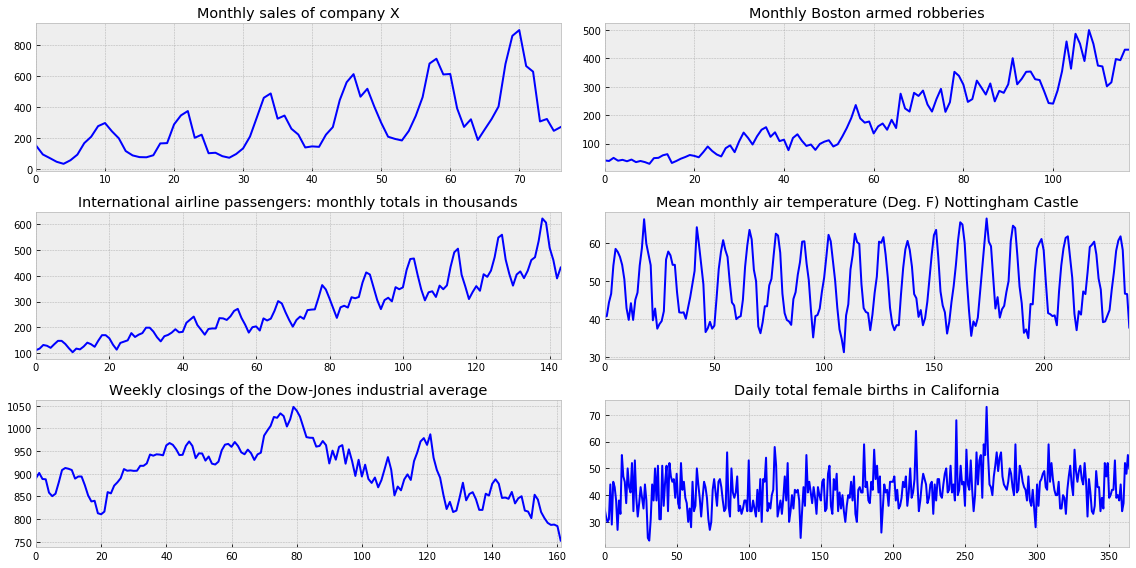

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Скользящее среднее

Возьмем dowjones_closing. У него нелинейный тренд, нет сезонности. Интерересно чем 

In [7]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [8]:
series = dowjones_closing["Close"]

mser = moving_average(series, 7)

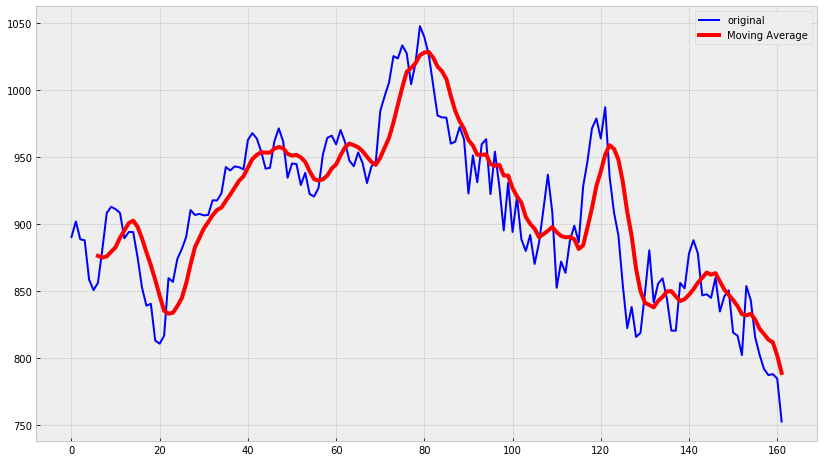

In [9]:

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(mser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [10]:
# Посмотрим на прогноз
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = np.append(new_series,pd.Series([new_series[-N:].mean()]))
    return new_series

In [11]:

series_pred = predict(series, 7, 50)

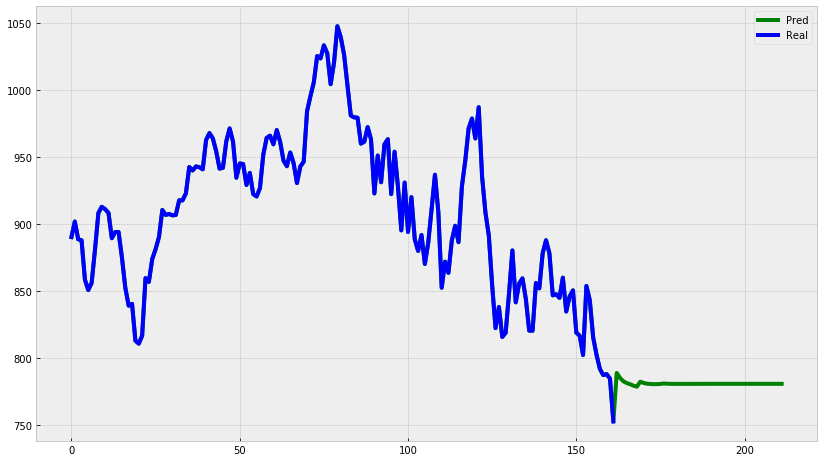

In [12]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(series, color='blue', linewidth='4', label='Real')
    plt.legend()

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат. По нескольким скользящим средним можно увидеть периоды резкого роста и резкого спада.

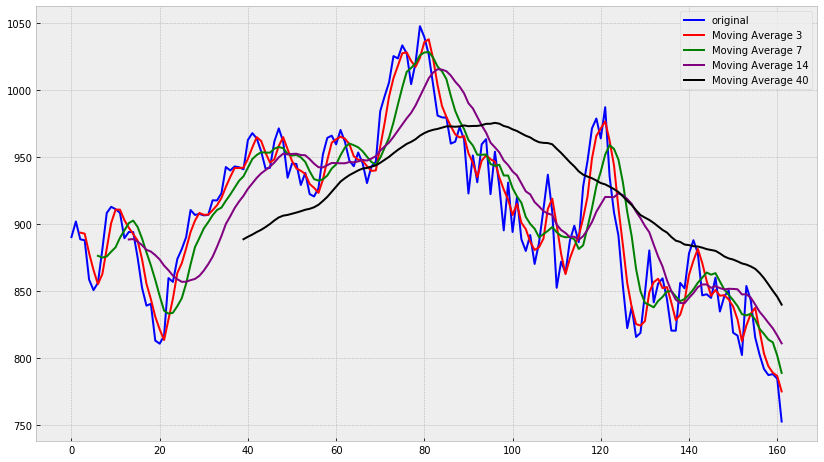

In [13]:
windows = [3,7,14,40]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        mser = moving_average(series, windows[i])
        plt.plot(mser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Модификацией обычной скользящей средней является взвешенная скользящая средняя.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

In [14]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

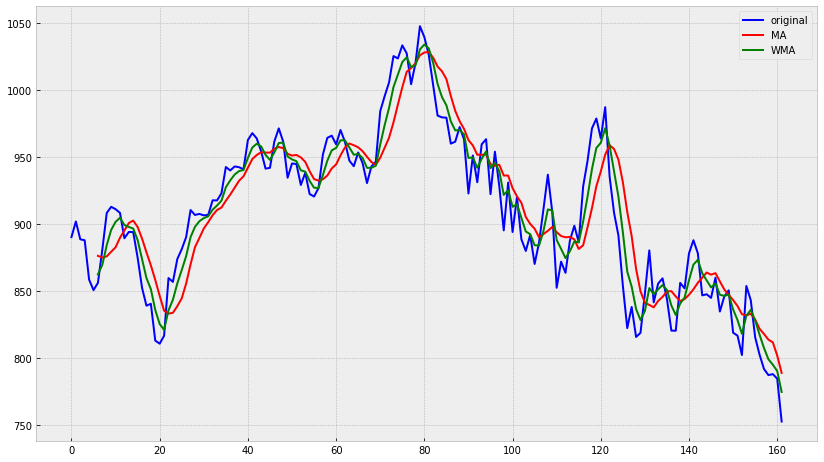

In [15]:
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [16]:
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

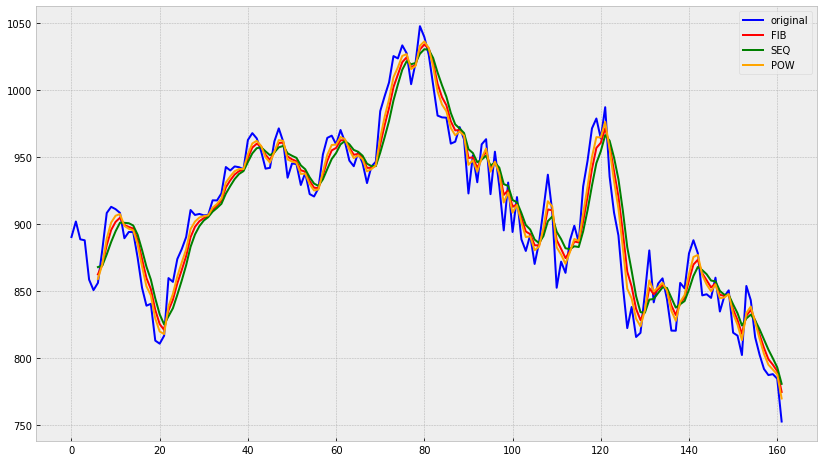

In [17]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

Степени двойки дают чуть лучший результат, но в общем сильно не отличаются

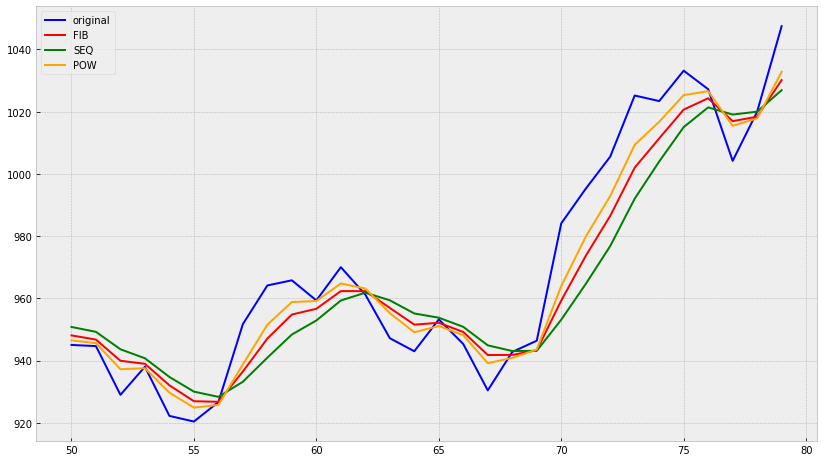

In [18]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series[50:80], color='blue',label='original')
    
    plt.plot(wma_fib[50:80], color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq[50:80], color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow[50:80], color='orange', linewidth='2', label='POW')
    plt.legend()

# Экспоненциальное сглаживание

Продолжаем развивать идею с историей. Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [19]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [20]:
ema = exponential_moving_average(series, 0.2)

In [21]:
len(ema)

162

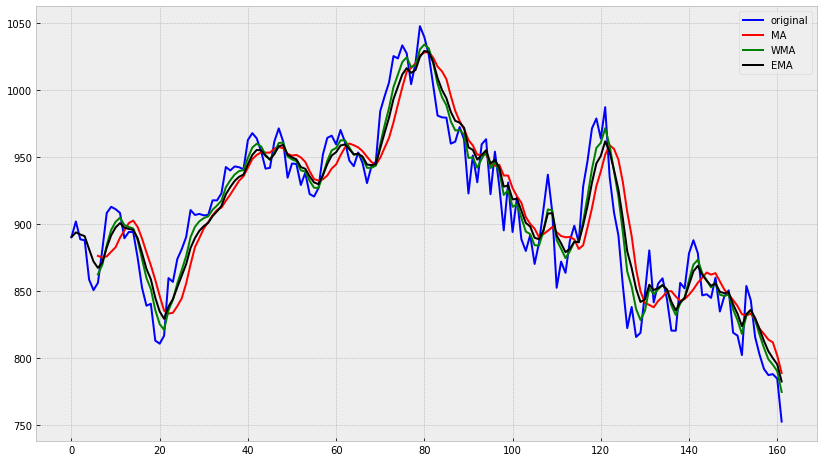

In [22]:
ema = exponential_moving_average(series, 0.3)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

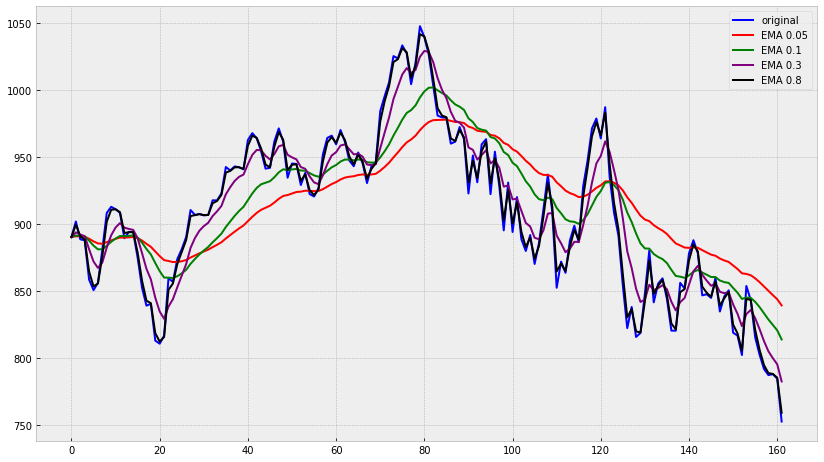

In [23]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

In [24]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return np.append(series,pd.Series(predictions)), pd.Series(result)

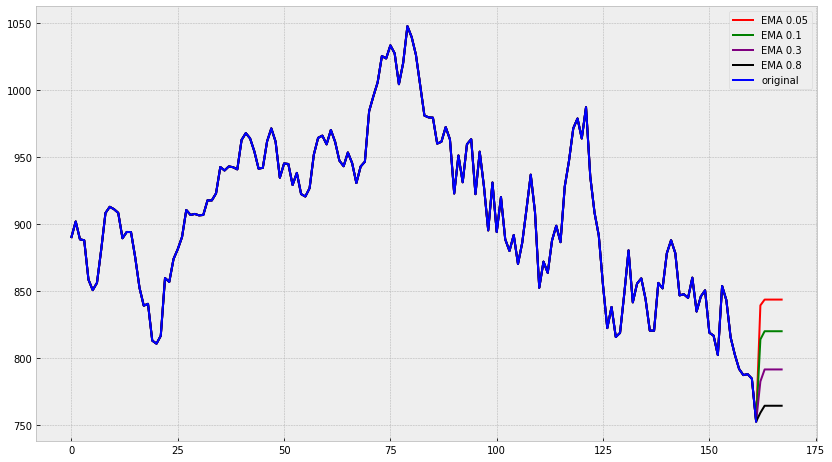

In [25]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(series, alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

# Двойное экспоненциальное сглаживание

In [26]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [27]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

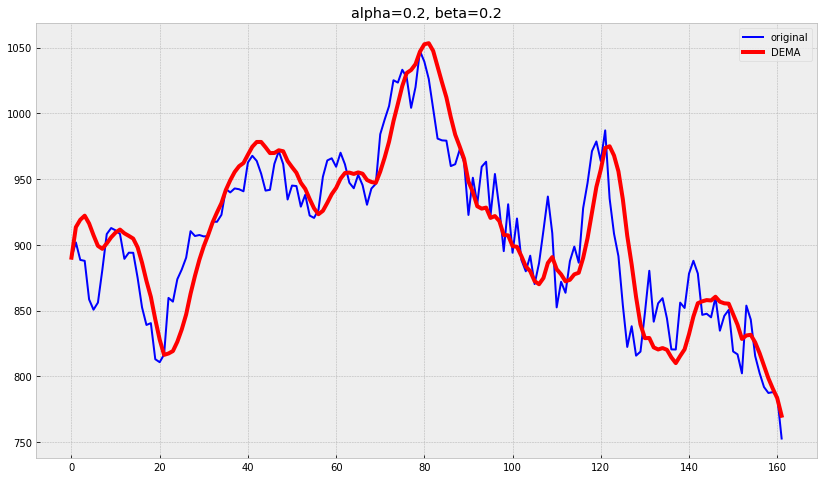

In [28]:
plot_dema(0.2, 0.2)

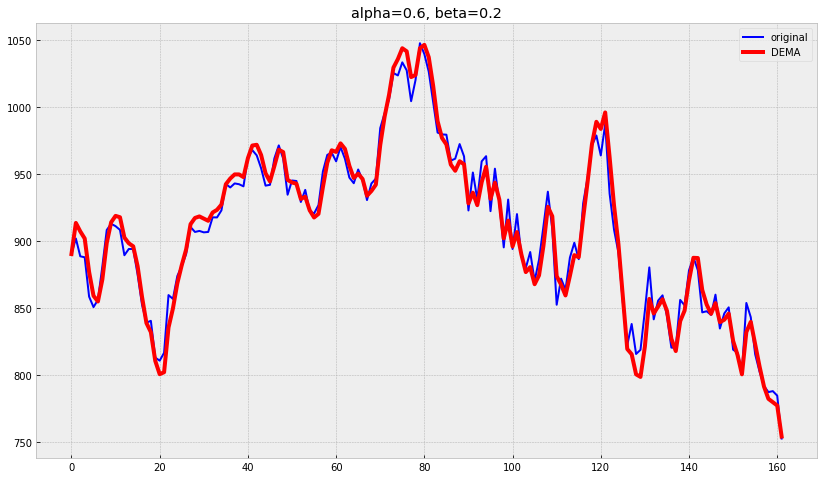

In [29]:
plot_dema(0.6, 0.2)

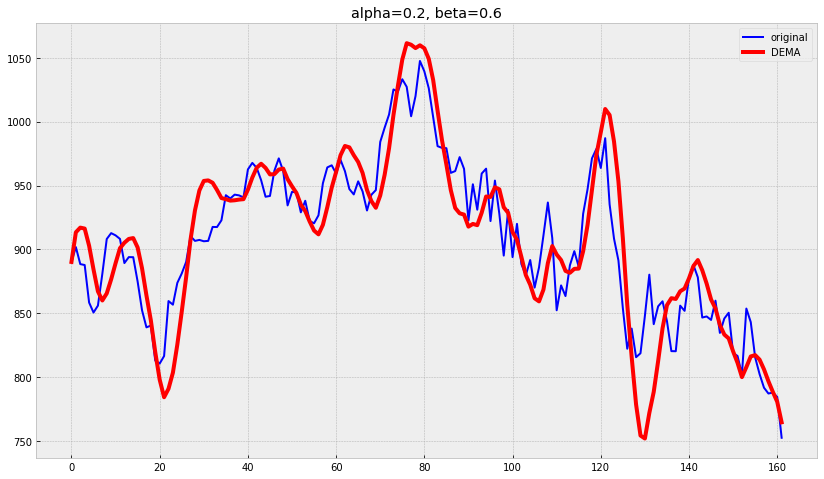

In [30]:
plot_dema(0.2, 0.6)

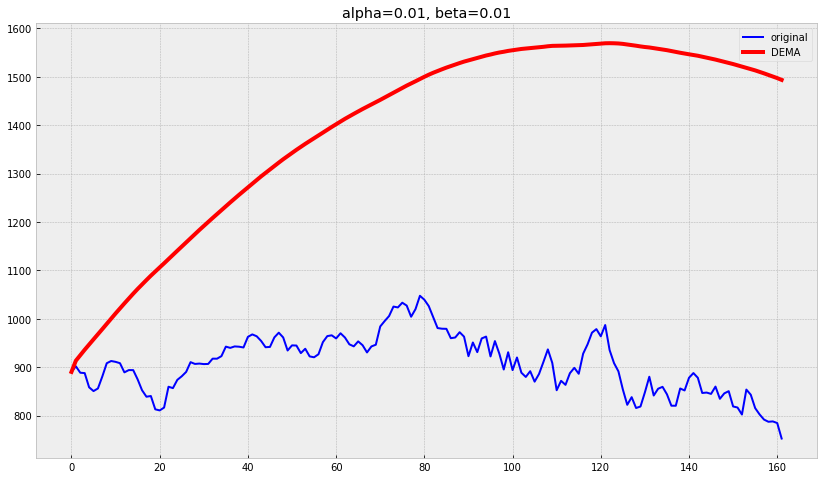

In [31]:
plot_dema(0.01, 0.01)

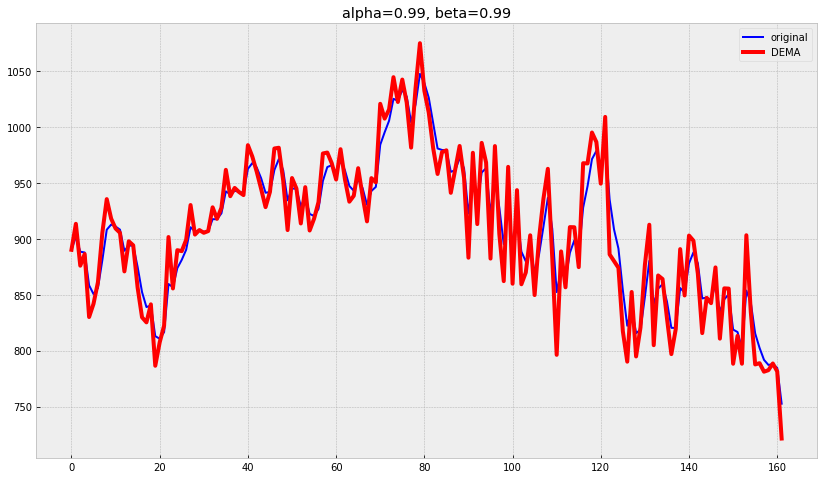

In [32]:
plot_dema(0.99, 0.99)

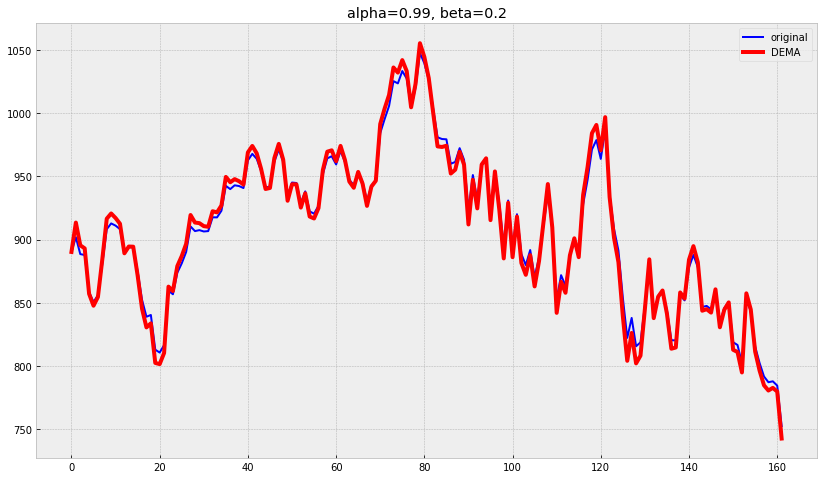

In [33]:
plot_dema(0.99, 0.2)

In [76]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result = np.append(result,level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result = np.append(result,level+trend)
        preds = np.append(preds,level+trend)

    return np.append(series,pd.Series(preds)), pd.Series(result)

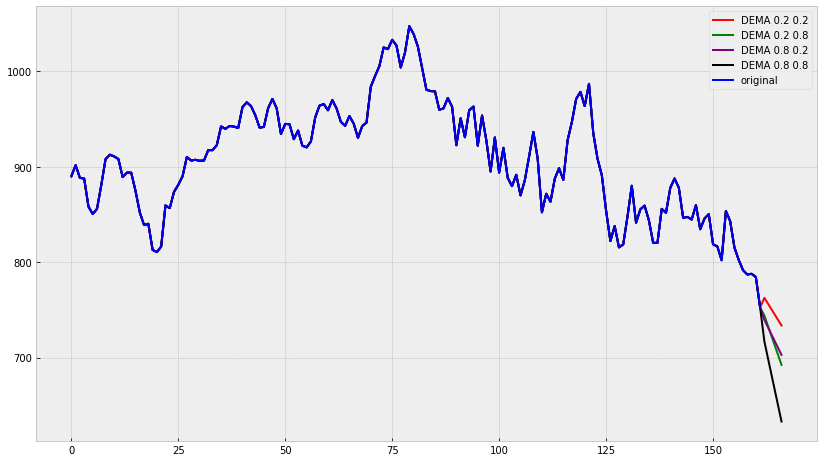

In [35]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(series, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [ ]:
#В прогнозе двойное сглаживание завалилось совсем

# Хольт-Винтерс

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [37]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [38]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [39]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [40]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=40):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

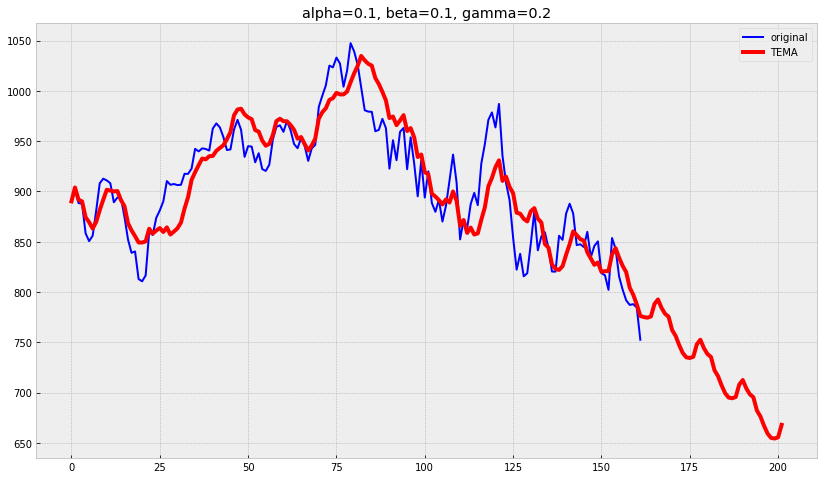

In [41]:
plot_tema(0.1, 0.1, 0.2)

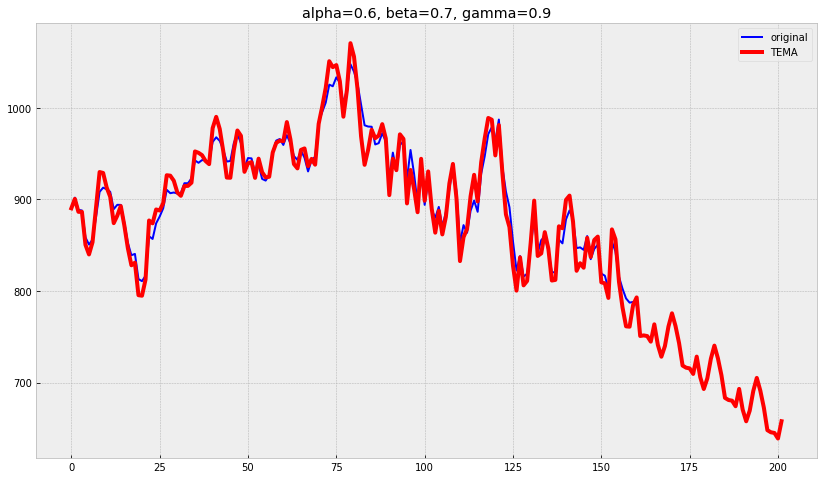

In [114]:
plot_tema(0.6, 0.7, 0.9)

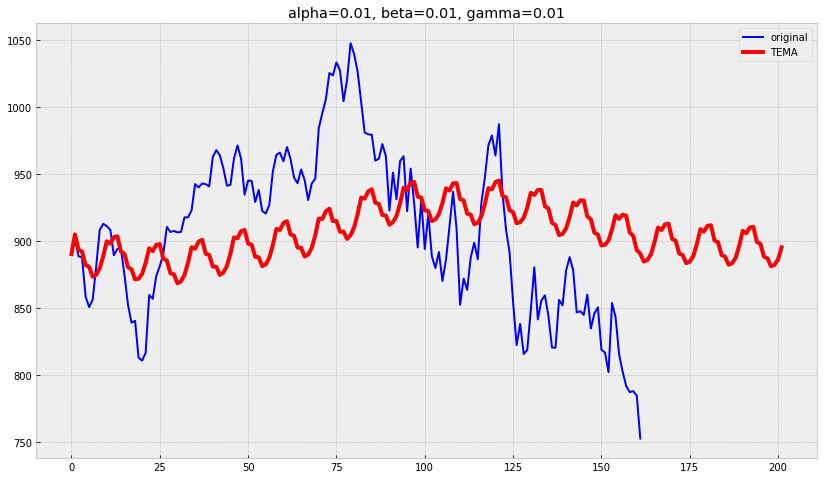

In [43]:
plot_tema(0.01, 0.01, 0.01)

# Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [44]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [45]:
len(series)

162

In [46]:
train, test, val = series[:140],series[140:155], series[155:]

In [47]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [48]:
opt = minimize(mse, x0=[0.5,0.5,0.5], bounds = ((0, 1), (0, 1), (0, 1)))

In [49]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 385.39504087047663
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00277396,  0.02553406, -0.00010232])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 21
   status: 0
  success: True
        x: array([0.52144505, 0.04017273, 0.16552953])


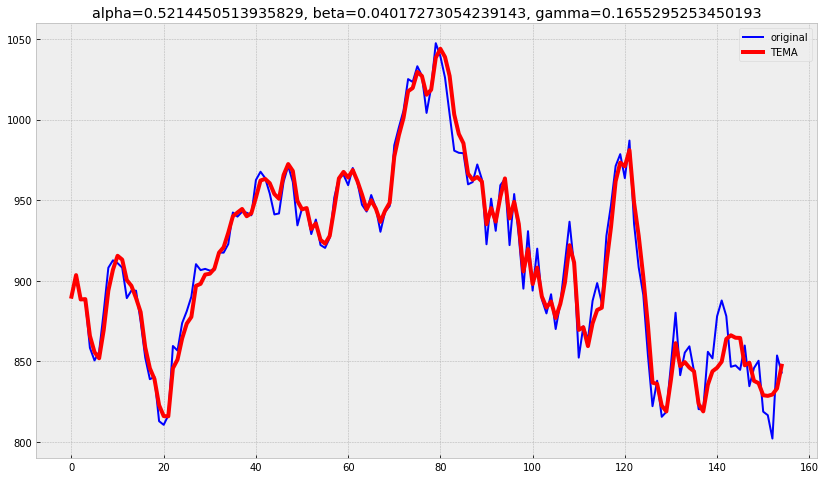

In [50]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:155], n_preds=len(test))

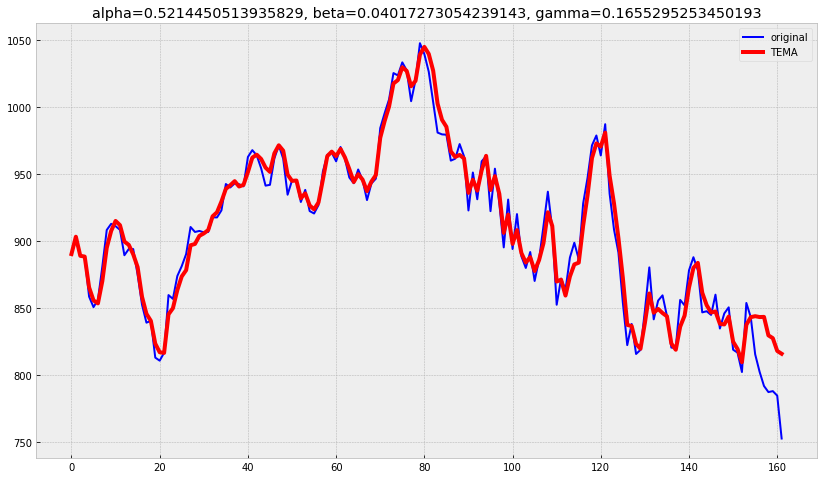

In [51]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:155], ser_to_plot=series, n_preds=len(val))

In [52]:
# КРОСС-ВАЛИДАЦИЯ
train, val = series[:160], series[160:]

In [57]:
from sklearn.model_selection import TimeSeriesSplit
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [58]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [59]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4921.319348469296
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.73114914e-03,  2.96086946e+03,  8.57762461e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 3
   status: 0
  success: True
        x: array([0.00055872, 0.        , 0.        ])


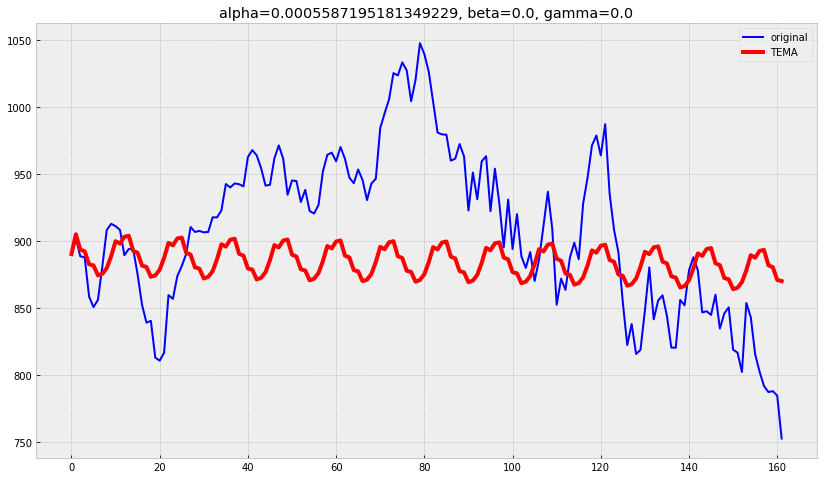

In [60]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

# Пока не прочувствовала почему подбор дал такие неудачные варианты.




In [ ]:
Теперь посмотрим в стациоанароном варианте

In [61]:
series = boxcox(dowjones_closing["Close"], 0)
series = np.diff(series, 1)

In [62]:
mser = moving_average(series, 7)

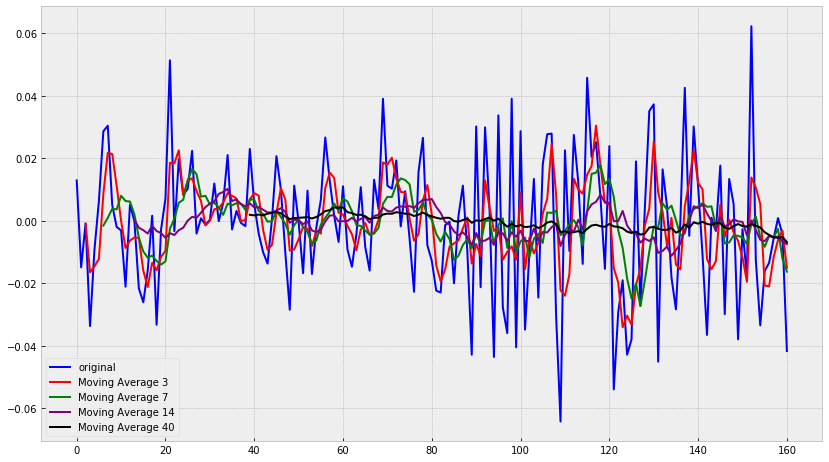

In [65]:
# скользящее среднее
windows = [3,7,14,40]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        mser = moving_average(series, windows[i])
        plt.plot(mser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

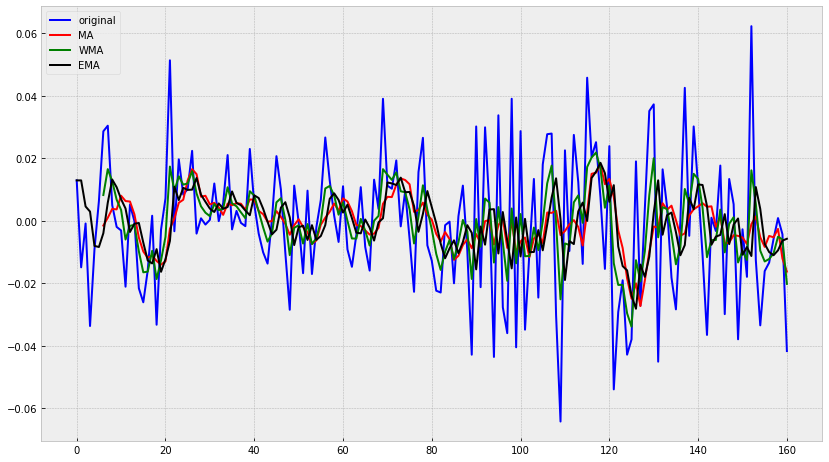

In [66]:
#Сравнение
ema = exponential_moving_average(series, 0.3)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

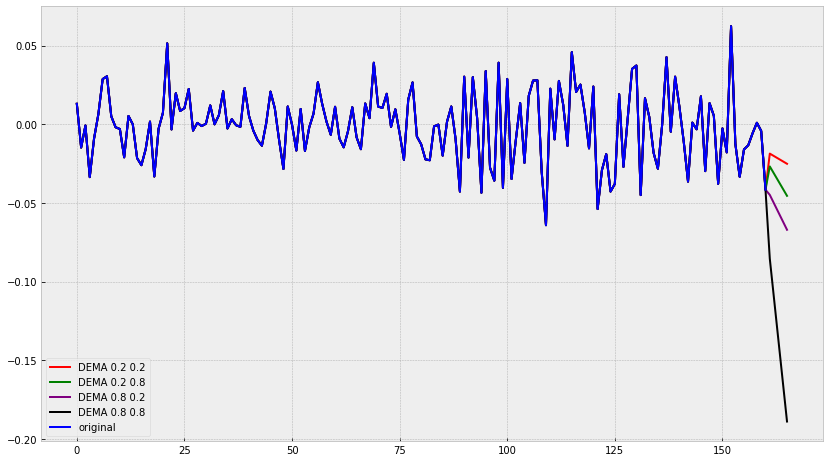

In [77]:
#Двойное экспоненциальное сглаживание
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(series, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Все тоже заваливание

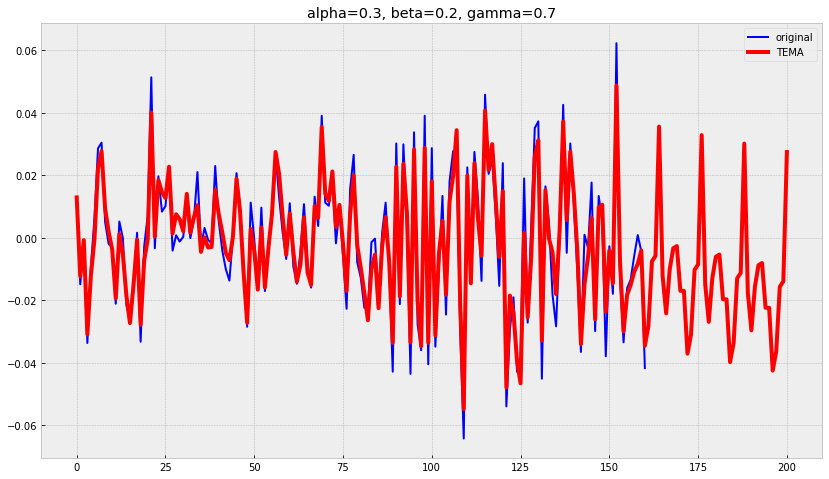

In [120]:
#Тройное
plot_tema(0.3, 0.2, 0.7,series,series)

Вывод:
Для красткосрочного прогноза можно взять экспоненциальое сглаживание.
Для средсрочного тройное сглаживание дает приблизительную картину